In [ ]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
nltk.download('wordnet') 
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras.regularizers import L2
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re
import json

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-05-23 18:43:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-23 18:43:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-23 18:43:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

# Data preprocessing

## Tokenize Data

In [ ]:
def tokenize_sentences(X):
  # Filter links, emojis
  X['tweets'] = X['tweets'].apply(lambda x: re.sub(r'http\S+|\@\w+|[^\w\s,]', '', x))
  X['tweets'] = X['tweets'].apply(lambda x: word_tokenize(x))
  # Remove stopwords
  stop_words = stopwords.words('english')
  X['tweets'] = X['tweets'].apply(lambda x: [y for y in x if x not in stop_words])
  return X

## Stemming 

In [ ]:
def stemming(X):
  stemmer = PorterStemmer()
  X['tweets'] = X['tweets'].apply(lambda x: [stemmer.stem(word) for word in x]) 
  X.head()
  return X

## Lemmitization

In [ ]:
def lemmatize_sentences(X):
  lemmatizer = WordNetLemmatizer()
  X['tweets'] = X['tweets'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
  return X

# Word Embedding

In [ ]:
MAX_SEQUENCE_LENGTH = 280
EMBEDDING_DIM = 300
def word_embedding(X_pd_train, X_pd_test):
  tokenizer = Tokenizer(num_words=20000)
  tokenizer.fit_on_texts(X_pd_train['tweets'])
  # The tokens are converted into sequences and then passed to the pad_sequences() function
  X_train = pad_sequences(tokenizer.texts_to_sequences(X_pd_train.tweets), maxlen = MAX_SEQUENCE_LENGTH)
  X_test = pad_sequences(tokenizer.texts_to_sequences(X_pd_test.tweets), maxlen = MAX_SEQUENCE_LENGTH)
  print('Indexing word vectors.')
  embeddings_index = {} 
  with open('glove.6B.300d.txt') as f:
    for line in f:
      values = line.split(sep=' ')
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  print('Found %s word vectors.' % len(embeddings_index))
  word_index = tokenizer.word_index
  embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector
  print ('Shape of Embedding Matrix: ',embedding_matrix.shape)
  return X_train, X_test, embedding_matrix, word_index, tokenizer

In [ ]:
!mkdir "drive/MyDrive/NLP Project/train"
!mkdir "drive/MyDrive/NLP Project/test"

TRAIN_FOLDER = "drive/MyDrive/NLP Project/train"
TEST_FOLDER = "drive/MyDrive/NLP Project/test"

mkdir: cannot create directory ‘drive/MyDrive/NLP Project/train’: No such file or directory
mkdir: cannot create directory ‘drive/MyDrive/NLP Project/test’: No such file or directory


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def train_data():
  df = pd.read_csv("drive/MyDrive/NLP Project/file.csv")
  df = df.drop(['Unnamed: 0'], axis = 1)
  df = df.dropna()

  X = df[df.columns[:-1]]
  y = df['labels']

  tokens = tokenize_sentences(X)
  X = stemming(tokens)
  X = lemmatize_sentences(X)

  X_pd_train, X_pd_test, y_pd_train, y_pd_test = train_test_split(X, y, train_size=0.8, random_state = 4526)
  X_pd_train.to_csv(f'{TRAIN_FOLDER}/X_train.csv')
  X_pd_test.to_csv(f'{TEST_FOLDER}/X_test.csv')
  y_pd_train.to_csv(f'{TRAIN_FOLDER}/y_train.csv')
  y_pd_test.to_csv(f'{TEST_FOLDER}/y_test.csv')
  X_train, X_test, embedding_matrix, word_index, tokenizer = word_embedding(X_pd_train, X_pd_test)
  return X_train, X_test, y_pd_train, y_pd_test, embedding_matrix, word_index, tokenizer

In [ ]:
def prepare_input(user_tweet, tokenizer):
  X = pd.DataFrame([user_tweet], columns=['tweets'])
  X = tokenize_sentences(X)
  X = stemming(X)
  X = lemmatize_sentences(X)

  return pad_sequences(tokenizer.texts_to_sequences(X.tweets), maxlen = MAX_SEQUENCE_LENGTH)

In [ ]:
X_train, X_test, y_pd_train, y_pd_test, embedding_matrix, word_index, tokenizer = train_data()

<ipython-input-3-941f1bb0b53e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tweets'] = X['tweets'].apply(lambda x: re.sub(r'http\S+|\@\w+|[^\w\s,]', '', x))
<ipython-input-3-941f1bb0b53e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tweets'] = X['tweets'].apply(lambda x: word_tokenize(x))
<ipython-input-3-941f1bb0b53e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Indexing word vectors.
Found 400000 word vectors.
Shape of Embedding Matrix:  (113288, 300)


In [ ]:
y_train = y_pd_train.to_numpy()
y_test = y_pd_test.to_numpy()
label_index, encoded_y_train = np.unique(y_pd_train, return_inverse=True)
_, encoded_y_test = np.unique(y_pd_test, return_inverse=True)
hot_y_train = to_categorical(encoded_y_train)
hot_y_test = to_categorical(encoded_y_test)

# Models

In [ ]:
from keras.layers import Embedding, Input, LSTM, Dense, Bidirectional

## LSTM model

In [ ]:
model1 = tf.keras.Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    Embedding(
        len(word_index) + 1,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False
      ),
    LSTM(64, return_sequences=True, recurrent_regularizer='l2'),
    LSTM(32, return_sequences=True, recurrent_regularizer='l2'),
    LSTM(16, recurrent_regularizer='l2'),
    Dense(3, activation='softmax', kernel_regularizer='l2')
])
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history1 = model1.fit(X_train, hot_y_train, batch_size=128, epochs=15, validation_data=(X_test, hot_y_test))

Epoch 1/15
1371/1371 [==============================] - 59s 35ms/step - loss: 0.8274 - accuracy: 0.6764 - val_loss: 0.6664 - val_accuracy: 0.7443
Epoch 2/15
1371/1371 [==============================] - 46s 34ms/step - loss: 0.6360 - accuracy: 0.7567 - val_loss: 0.6081 - val_accuracy: 0.7700
Epoch 3/15
1371/1371 [==============================] - 47s 34ms/step - loss: 0.5910 - accuracy: 0.7764 - val_loss: 0.5864 - val_accuracy: 0.7807
Epoch 4/15
1371/1371 [==============================] - 46s 34ms/step - loss: 0.5649 - accuracy: 0.7876 - val_loss: 0.5705 - val_accuracy: 0.7867
Epoch 5/15
1371/1371 [==============================] - 47s 34ms/step - loss: 0.5452 - accuracy: 0.7964 - val_loss: 0.5760 - val_accuracy: 0.7829
Epoch 6/15
1371/1371 [==============================] - 47s 34ms/step - loss: 0.5307 - accuracy: 0.8032 - val_loss: 0.5635 - val_accuracy: 0.7902
Epoch 7/15
1371/1371 [==============================] - 47s 35ms/step - loss: 0.5182 - accuracy: 0.8085 - val_loss: 0.5576 -

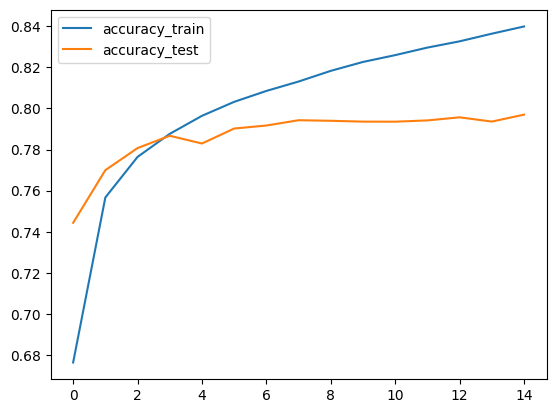

In [ ]:
plt.plot(history1.history['accuracy'], label='accuracy_train')
plt.plot(history1.history['val_accuracy'], label='accuracy_test')
plt.legend()
plt.show()

In [ ]:
model2 = tf.keras.Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    Embedding(
        len(word_index) + 1,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False
      ),
    LSTM(64, return_sequences=True, recurrent_regularizer='l2'),
    LSTM(32, recurrent_regularizer='l2'),
    Dense(3, activation='softmax', kernel_regularizer='l2')
])
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history2 = model2.fit(X_train, hot_y_train, batch_size=64, epochs=15, validation_data=(X_test, hot_y_test))

Epoch 1/15
2742/2742 [==============================] - 71s 25ms/step - loss: 0.7687 - accuracy: 0.6922 - val_loss: 0.6456 - val_accuracy: 0.7528
Epoch 2/15
2742/2742 [==============================] - 62s 23ms/step - loss: 0.6124 - accuracy: 0.7652 - val_loss: 0.5951 - val_accuracy: 0.7741
Epoch 3/15
2742/2742 [==============================] - 62s 23ms/step - loss: 0.5711 - accuracy: 0.7839 - val_loss: 0.5803 - val_accuracy: 0.7778
Epoch 4/15
2742/2742 [==============================] - 62s 23ms/step - loss: 0.5465 - accuracy: 0.7942 - val_loss: 0.5630 - val_accuracy: 0.7887
Epoch 5/15
2742/2742 [==============================] - 67s 24ms/step - loss: 0.5303 - accuracy: 0.8007 - val_loss: 0.5671 - val_accuracy: 0.7874
Epoch 6/15
2742/2742 [==============================] - 67s 24ms/step - loss: 0.5154 - accuracy: 0.8081 - val_loss: 0.5643 - val_accuracy: 0.7891
Epoch 7/15
2742/2742 [==============================] - 67s 24ms/step - loss: 0.5034 - accuracy: 0.8136 - val_loss: 0.5519 -

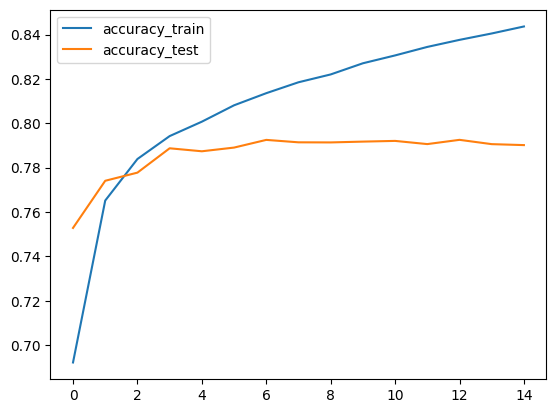

In [ ]:
plt.plot(history2.history['accuracy'], label='accuracy_train')
plt.plot(history2.history['val_accuracy'], label='accuracy_test')
plt.legend()
plt.show()

In [ ]:
model3 = tf.keras.Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    Embedding(
        len(word_index) + 1,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=True
      ),
    LSTM(32, recurrent_regularizer='l2'),
    Dense(16, activation='relu', kernel_regularizer='l2'),
    Dense(8, activation='relu', kernel_regularizer='l2'),
    Dense(3, activation='softmax', kernel_regularizer='l2')
])
model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history3 = model3.fit(X_train, hot_y_train, batch_size=128, epochs=15, validation_data=(X_test, hot_y_test))

Epoch 1/15
1371/1371 [==============================] - 89s 63ms/step - loss: 0.6666 - accuracy: 0.7981 - val_loss: 0.4829 - val_accuracy: 0.8670
Epoch 2/15
1371/1371 [==============================] - 37s 27ms/step - loss: 0.4269 - accuracy: 0.8843 - val_loss: 0.4445 - val_accuracy: 0.8726
Epoch 3/15
1371/1371 [==============================] - 35s 25ms/step - loss: 0.3773 - accuracy: 0.9016 - val_loss: 0.4444 - val_accuracy: 0.8719
Epoch 4/15
1371/1371 [==============================] - 35s 26ms/step - loss: 0.3441 - accuracy: 0.9136 - val_loss: 0.4409 - val_accuracy: 0.8725
Epoch 5/15
1371/1371 [==============================] - 34s 25ms/step - loss: 0.3186 - accuracy: 0.9243 - val_loss: 0.4553 - val_accuracy: 0.8699
Epoch 6/15
1371/1371 [==============================] - 34s 25ms/step - loss: 0.2991 - accuracy: 0.9320 - val_loss: 0.4601 - val_accuracy: 0.8683
Epoch 7/15
1371/1371 [==============================] - 34s 24ms/step - loss: 0.2808 - accuracy: 0.9401 - val_loss: 0.4719 -

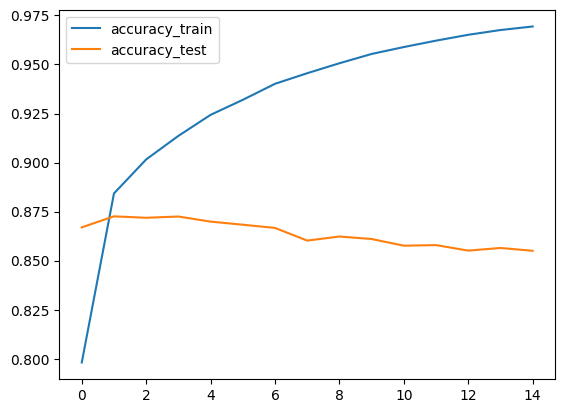

In [ ]:
plt.plot(history3.history['accuracy'], label='accuracy_train')
plt.plot(history3.history['val_accuracy'], label='accuracy_test')
plt.legend()
plt.show()

In [ ]:
model4 = tf.keras.Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    Embedding(
        len(word_index) + 1,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=True
      ),
    LSTM(32, recurrent_regularizer='l2'),
    Dense(3, activation='softmax', kernel_regularizer='l2')
])
model4.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history4 = model4.fit(X_train, hot_y_train, batch_size=128, epochs=15, validation_data=(X_test, hot_y_test))

Epoch 1/15
1371/1371 [==============================] - 73s 51ms/step - loss: 0.5713 - accuracy: 0.8008 - val_loss: 0.4247 - val_accuracy: 0.8585
Epoch 2/15
1371/1371 [==============================] - 35s 26ms/step - loss: 0.3676 - accuracy: 0.8815 - val_loss: 0.3908 - val_accuracy: 0.8719
Epoch 3/15
1371/1371 [==============================] - 36s 26ms/step - loss: 0.3181 - accuracy: 0.8988 - val_loss: 0.3891 - val_accuracy: 0.8705
Epoch 4/15
1371/1371 [==============================] - 33s 24ms/step - loss: 0.2880 - accuracy: 0.9122 - val_loss: 0.4101 - val_accuracy: 0.8665
Epoch 5/15
1371/1371 [==============================] - 34s 24ms/step - loss: 0.2646 - accuracy: 0.9217 - val_loss: 0.4195 - val_accuracy: 0.8608
Epoch 6/15
1371/1371 [==============================] - 34s 25ms/step - loss: 0.2452 - accuracy: 0.9303 - val_loss: 0.4330 - val_accuracy: 0.8601
Epoch 7/15
1371/1371 [==============================] - 34s 25ms/step - loss: 0.2298 - accuracy: 0.9369 - val_loss: 0.4291 -

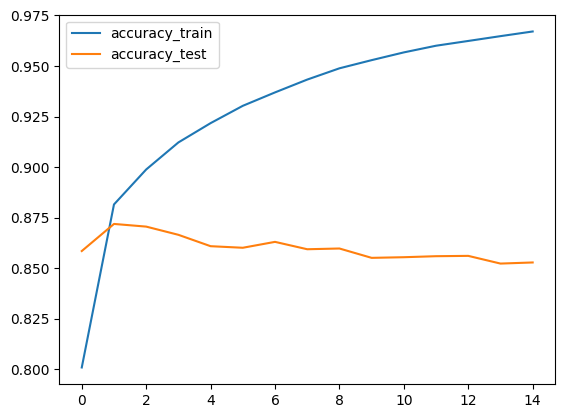

In [ ]:
plt.plot(history4.history['accuracy'], label='accuracy_train')
plt.plot(history4.history['val_accuracy'], label='accuracy_test')
plt.legend()
plt.show()

## Bi-LSTM model

In [ ]:
model1_bi = tf.keras.Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    Embedding(
        len(word_index) + 1,
        EMBEDDING_DIM,
        batch_size = 128,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False
      ),
    Bidirectional(LSTM(128, activation = 'tanh', return_sequences=True, recurrent_regularizer='l2')),
    Bidirectional(LSTM(128, activation = 'tanh', recurrent_regularizer='l2')),
    Dense(64, activation = 'relu', kernel_regularizer='l2'),
    Dense(64, activation = 'relu', kernel_regularizer='l2'),
    Dense(16, activation = 'relu', kernel_regularizer='l2'),
    Dense(3, activation = 'softmax', kernel_regularizer='l2')
])
model1_bi.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
history1_bi = model1_bi.fit(X_train, hot_y_train, batch_size = 128, epochs=15, validation_data=(X_test, hot_y_test))

Epoch 1/15
1371/1371 [==============================] - 162s 112ms/step - loss: 1.0008 - accuracy: 0.6793 - val_loss: 0.7176 - val_accuracy: 0.7473
Epoch 2/15
1371/1371 [==============================] - 152s 111ms/step - loss: 0.6693 - accuracy: 0.7660 - val_loss: 0.6439 - val_accuracy: 0.7811
Epoch 3/15
1371/1371 [==============================] - 152s 111ms/step - loss: 0.6269 - accuracy: 0.7859 - val_loss: 0.6242 - val_accuracy: 0.7897
Epoch 4/15
1371/1371 [==============================] - 152s 111ms/step - loss: 0.6004 - accuracy: 0.7969 - val_loss: 0.6231 - val_accuracy: 0.7886
Epoch 5/15
1371/1371 [==============================] - 152s 111ms/step - loss: 0.5797 - accuracy: 0.8066 - val_loss: 0.6069 - val_accuracy: 0.7929
Epoch 6/15
1371/1371 [==============================] - 144s 105ms/step - loss: 0.5623 - accuracy: 0.8141 - val_loss: 0.6030 - val_accuracy: 0.7953
Epoch 7/15
1371/1371 [==============================] - 152s 111ms/step - loss: 0.5451 - accuracy: 0.8229 - val_

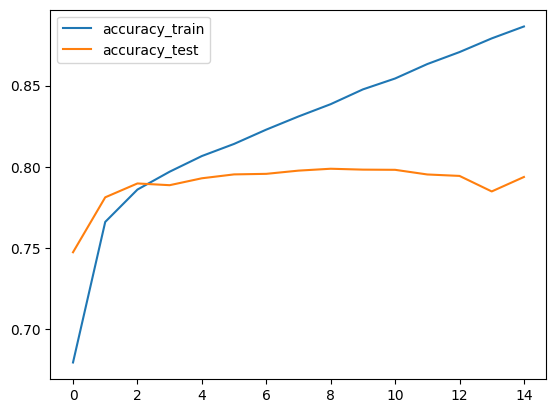

In [ ]:
plt.plot(history1_bi.history['accuracy'], label='accuracy_train')
plt.plot(history1_bi.history['val_accuracy'], label='accuracy_test')
plt.legend()
plt.show()

In [ ]:
model2_bi = tf.keras.Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    Embedding(
        len(word_index) + 1,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False
      ),
    Bidirectional(LSTM(64, return_sequences=True, recurrent_regularizer='l2')),
    Bidirectional(LSTM(32, return_sequences=True, recurrent_regularizer='l2')),
    Bidirectional(LSTM(16, recurrent_regularizer='l2')),
    Dense(64, activation = 'relu', kernel_regularizer='l2'),
    Dense(3, activation = 'softmax', kernel_regularizer='l2')
])
model2_bi.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history2_bi = model2_bi.fit(X_train, hot_y_train, batch_size = 64, epochs= 15, validation_data=(X_test, hot_y_test))

Epoch 1/15
2742/2742 [==============================] - 179s 61ms/step - loss: 0.8001 - accuracy: 0.7021 - val_loss: 0.6581 - val_accuracy: 0.7577
Epoch 2/15
2742/2742 [==============================] - 171s 62ms/step - loss: 0.6109 - accuracy: 0.7766 - val_loss: 0.6005 - val_accuracy: 0.7792
Epoch 3/15
2742/2742 [==============================] - 163s 59ms/step - loss: 0.5704 - accuracy: 0.7950 - val_loss: 0.5758 - val_accuracy: 0.7930
Epoch 4/15
2742/2742 [==============================] - 169s 62ms/step - loss: 0.5448 - accuracy: 0.8055 - val_loss: 0.5697 - val_accuracy: 0.7941
Epoch 5/15
2742/2742 [==============================] - 171s 62ms/step - loss: 0.5235 - accuracy: 0.8150 - val_loss: 0.5658 - val_accuracy: 0.7983
Epoch 6/15
2742/2742 [==============================] - 173s 63ms/step - loss: 0.5047 - accuracy: 0.8237 - val_loss: 0.5650 - val_accuracy: 0.7969
Epoch 7/15
2742/2742 [==============================] - 172s 63ms/step - loss: 0.4883 - accuracy: 0.8312 - val_loss: 0

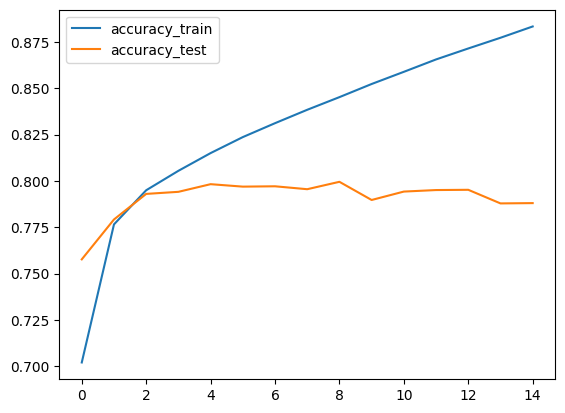

In [ ]:
plt.plot(history2_bi.history['accuracy'], label='accuracy_train')
plt.plot(history2_bi.history['val_accuracy'], label='accuracy_test')
plt.legend()
plt.show()

In [ ]:
model3_bi = tf.keras.Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    Embedding(
        len(word_index) + 1,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=True
      ),
    Bidirectional(LSTM(64, recurrent_regularizer='l2')),
    Dense(64, activation = 'relu', kernel_regularizer='l2'),
    Dense(3, activation = 'softmax', kernel_regularizer='l2')
])
model3_bi.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history3_bi = model3_bi.fit(X_train, hot_y_train, batch_size = 64, epochs= 15, validation_data=(X_test, hot_y_test))

Epoch 1/15
2742/2742 [==============================] - 149s 52ms/step - loss: 0.5710 - accuracy: 0.8168 - val_loss: 0.4187 - val_accuracy: 0.8676
Epoch 2/15
2742/2742 [==============================] - 103s 38ms/step - loss: 0.3695 - accuracy: 0.8864 - val_loss: 0.3962 - val_accuracy: 0.8744
Epoch 3/15
2742/2742 [==============================] - 101s 37ms/step - loss: 0.3277 - accuracy: 0.9016 - val_loss: 0.3963 - val_accuracy: 0.8738
Epoch 4/15
2742/2742 [==============================] - 98s 36ms/step - loss: 0.3003 - accuracy: 0.9132 - val_loss: 0.4105 - val_accuracy: 0.8698
Epoch 5/15
2742/2742 [==============================] - 96s 35ms/step - loss: 0.2766 - accuracy: 0.9242 - val_loss: 0.4187 - val_accuracy: 0.8650
Epoch 6/15
2742/2742 [==============================] - 95s 35ms/step - loss: 0.2579 - accuracy: 0.9322 - val_loss: 0.4292 - val_accuracy: 0.8671
Epoch 7/15
2742/2742 [==============================] - 95s 35ms/step - loss: 0.2415 - accuracy: 0.9391 - val_loss: 0.443

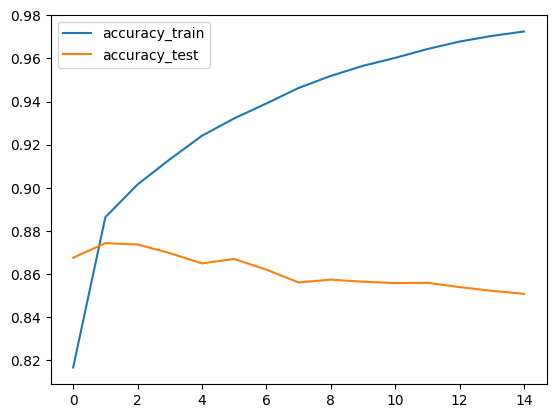

In [ ]:
plt.plot(history3_bi.history['accuracy'], label='accuracy_train')
plt.plot(history3_bi.history['val_accuracy'], label='accuracy_test')
plt.legend()
plt.show()

In [ ]:
model4_bi = tf.keras.Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    Embedding(
        len(word_index) + 1,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=True
      ),
    Bidirectional(LSTM(32, recurrent_regularizer='l2')),
    Dense(3, activation = 'softmax', kernel_regularizer='l2')
])
model4_bi.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history4_bi = model4_bi.fit(X_train, hot_y_train, batch_size = 64, epochs= 15, validation_data=(X_test, hot_y_test))

Epoch 1/15
2742/2742 [==============================] - 130s 46ms/step - loss: 0.5331 - accuracy: 0.8124 - val_loss: 0.4189 - val_accuracy: 0.8558
Epoch 2/15
2742/2742 [==============================] - 88s 32ms/step - loss: 0.3527 - accuracy: 0.8841 - val_loss: 0.3872 - val_accuracy: 0.8693
Epoch 3/15
2742/2742 [==============================] - 92s 33ms/step - loss: 0.3088 - accuracy: 0.9015 - val_loss: 0.3879 - val_accuracy: 0.8691
Epoch 4/15
2742/2742 [==============================] - 91s 33ms/step - loss: 0.2799 - accuracy: 0.9143 - val_loss: 0.3945 - val_accuracy: 0.8686
Epoch 5/15
2742/2742 [==============================] - 86s 31ms/step - loss: 0.2570 - accuracy: 0.9248 - val_loss: 0.4127 - val_accuracy: 0.8664
Epoch 6/15
2742/2742 [==============================] - 86s 31ms/step - loss: 0.2378 - accuracy: 0.9326 - val_loss: 0.4184 - val_accuracy: 0.8648
Epoch 7/15
2742/2742 [==============================] - 86s 31ms/step - loss: 0.2224 - accuracy: 0.9407 - val_loss: 0.4391 

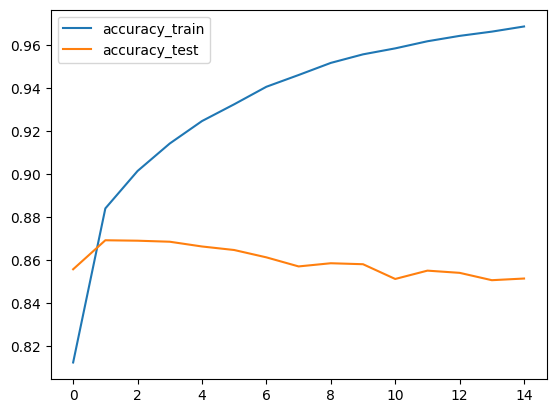

In [ ]:
plt.plot(history4_bi.history['accuracy'], label='accuracy_train')
plt.plot(history4_bi.history['val_accuracy'], label='accuracy_test')
plt.legend()
plt.show()

## Combined plots

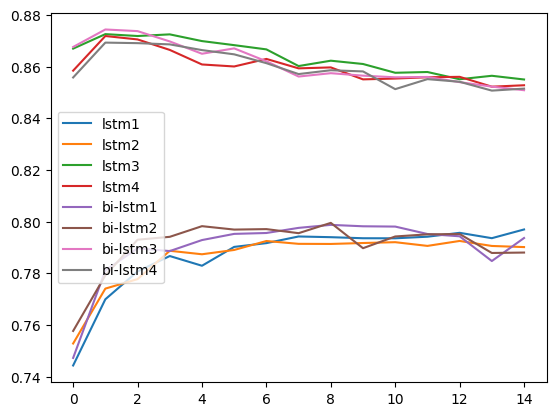

In [ ]:
plt.plot(history1.history['val_accuracy'], label='lstm1')
plt.plot(history2.history['val_accuracy'], label='lstm2')
plt.plot(history3.history['val_accuracy'], label='lstm3')
plt.plot(history4.history['val_accuracy'], label='lstm4')
plt.plot(history1_bi.history['val_accuracy'], label='bi-lstm1')
plt.plot(history2_bi.history['val_accuracy'], label='bi-lstm2')
plt.plot(history3_bi.history['val_accuracy'], label='bi-lstm3')
plt.plot(history4_bi.history['val_accuracy'], label='bi-lstm4')
plt.legend()
plt.show()

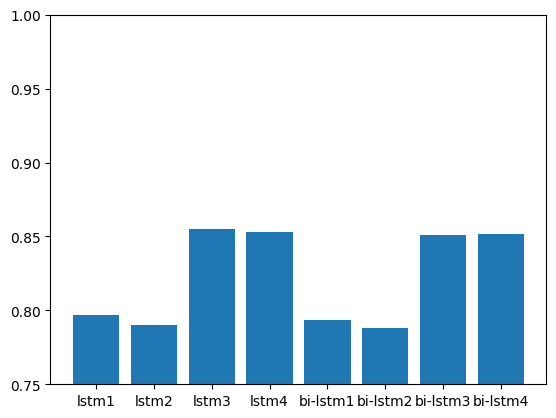

In [ ]:
plt.bar([
    'lstm1',
    'lstm2',
    'lstm3',
    'lstm4',
    'bi-lstm1',
    'bi-lstm2',
    'bi-lstm3',
    'bi-lstm4',
  ],
  np.array([
    history1.history['val_accuracy'][-1],
    history2.history['val_accuracy'][-1],
    history3.history['val_accuracy'][-1],
    history4.history['val_accuracy'][-1],
    history1_bi.history['val_accuracy'][-1],
    history2_bi.history['val_accuracy'][-1],
    history3_bi.history['val_accuracy'][-1],
    history4_bi.history['val_accuracy'][-1],
  ]) - 0.75,
  bottom=0.75)
plt.yticks([0.75 + i * 0.05 for i in range(6)])
plt.show()

# Save models

In [ ]:
MODEL_FOLDER = "drive/MyDrive/NLP Project/models"

In [ ]:
!mkdir "drive/MyDrive/NLP Project/models"

mkdir: cannot create directory ‘drive/MyDrive/NLP Project/models’: File exists


In [ ]:
model1.save(f'{MODEL_FOLDER}/model1')
model2.save(f'{MODEL_FOLDER}/model2')
model3.save(f'{MODEL_FOLDER}/model3')
model4.save(f'{MODEL_FOLDER}/model4')

model1_bi.save(f'{MODEL_FOLDER}/model1_bi')
model2_bi.save(f'{MODEL_FOLDER}/model2_bi')
model3_bi.save(f'{MODEL_FOLDER}/model3_bi')
model4_bi.save(f'{MODEL_FOLDER}/model4_bi')

KeyboardInterrupt: ignored

# Load models

In [ ]:
model1 = tf.keras.models.load_model(f'{MODEL_FOLDER}/model1')
model2 = tf.keras.models.load_model(f'{MODEL_FOLDER}/model2')
model3 = tf.keras.models.load_model(f'{MODEL_FOLDER}/model3')
model4 = tf.keras.models.load_model(f'{MODEL_FOLDER}/model4')

model1_bi = tf.keras.models.load_model(f'{MODEL_FOLDER}/model1_bi')
model2_bi = tf.keras.models.load_model(f'{MODEL_FOLDER}/model2_bi')
model3_bi = tf.keras.models.load_model(f'{MODEL_FOLDER}/model3_bi')
model4_bi = tf.keras.models.load_model(f'{MODEL_FOLDER}/model4_bi')

# Take user input

In [ ]:
# Select model from above
model = model3_bi
data = input("Enter tweet: ")
processed_data = prepare_input(data, tokenizer)

predictions = model.predict(processed_data)
print(label_index[np.argmax(predictions)])

Enter tweet: ChatGPT, the so-called AI marvel, disappoints yet again with its subpar performance. Its responses are often nonsensical and fail to grasp even basic queries. Don't waste your time expecting any meaningful interaction from ChatGPT. It's a prime example of AI gone wrong. #AI #ChatGPT #Underwhelming
1/1 [==============================] - 0s 34ms/step
bad
